**Vector autoregression (VAR)** model used to capture the relationship between multiple quantities as they change over time.

Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. That is, the relationship between the time series involved is bi-directional.

A *$K$-dimensional* VAR model of *order p*, denoted as VAR(p) consider each variable in $y_k$ system. Here *$K$* is the number of timeseries in consideration.

For eg. For *$K = 2$* i.e. a 2 dimensional VAR(1) model is:

### $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \epsilon_{1,t}$
### $y_{2,t} = c_1 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \epsilon_{2,t}$

If we carry out this further, For *$K = 2$* i.e. a 2 dimensional VAR(3) model is:

### $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \epsilon_{1,t}$
### $y_{2,t} = c_1 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \epsilon_{2,t}$

We clearly see the interdependence of both the equations, since the term $y_2$ exists in the equation of $y_1$ and vice versa.

**Steps for implmenting VAR Model**

 - Examine the Data
 - Visualize the data
 - Test for stationarity
 - Select the appropriate order of p
 - Instantiate the model and fit it to a training set
 - If necessary, invert the earlier transformation
 - Evaluate model predictions against test set
 - Forecast the future


In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

Loading the datasets. Here these two datasets have interdependent timeseries.

**Step 1 : Loading the Datasets**

In [4]:
df = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\M2SLMoneyStock.csv', index_col=[0], parse_dates=True)
df.index.freq = 'MS'
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [5]:
sp = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\PCEPersonalSpending.csv', index_col=[0], parse_dates=True)
sp.index.freq = 'MS'
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [7]:
df = df.join(sp)

In [10]:
df = df.dropna()
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


<AxesSubplot:xlabel='Date'>

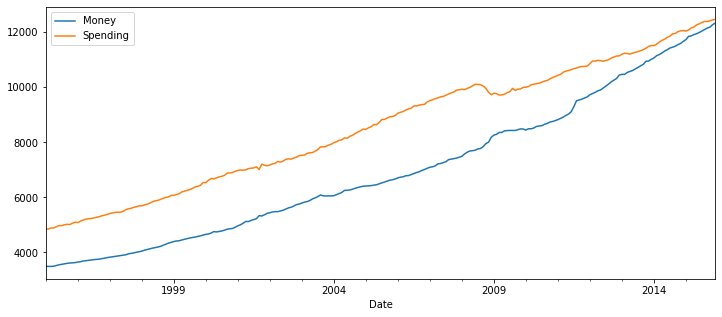

In [11]:
df.plot(figsize=(12,5))

**Step 2 : Checking for stationarity**

In [12]:
def parse_results(results):
    if results[1] <= 0.05:
        print("Time-series is Stationary")
    else:
        print("Time-series is Non-Stationary")

result1 = adfuller(df['Money'])
parse_results(result1)

Time-series is Non-Stationary


In [13]:
result1 = adfuller(df['Spending'])
parse_results(result1)

Time-series is Non-Stationary


So, both the series are non-stationary

**Step 3 : Making Series Stationary**

In [19]:
df_transformed = df.diff()
df_transformed = df_transformed.dropna()

In [21]:
parse_results(adfuller(df_transformed['Money']))

Time-series is Non-Stationary


In [22]:
parse_results(adfuller(df_transformed['Spending']))

Time-series is Stationary


Since Money is still non-stationary we have to run diff on both the columns.

In [23]:
df_transformed = df_transformed.diff().dropna()

In [24]:
parse_results(adfuller(df_transformed['Money']))

Time-series is Stationary


In [25]:
parse_results(adfuller(df_transformed['Spending']))

Time-series is Stationary


Cool, now both the series are stationary.

**Step 4 : Train Test split**

In [27]:
len(df_transformed)

250

In [28]:
nobs = 12
train = df_transformed[:-nobs] # start = begining of DF --> -12 from the end | We get 250-12 data points in train set
test = df_transformed[-nobs:] # start = Start at -12 -> end of the dataframe | We get 12 data points in test set

**Step 5 : Choosing the order of VAR -> p value**

In [29]:
model = VAR(train)

for p in range(8):
    result = model.fit(p)
    print(f"ORDER {p} | AIC -> {result.aic}")

ORDER 0 | AIC -> 14.74710921809045
ORDER 1 | AIC -> 14.178610495220896
ORDER 2 | AIC -> 13.955189367163703
ORDER 3 | AIC -> 13.849518291541038
ORDER 4 | AIC -> 13.827950574458281
ORDER 5 | AIC -> 13.78730034460964
ORDER 6 | AIC -> 13.799076756885809
ORDER 7 | AIC -> 13.79763872791397


It seems that we should use p = 5 as it has lower AIC

**Step 6 : Modelling**

In [30]:
model = VAR(train)
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Dec, 2021
Time:                     20:35:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

**Step 7 : Prediction for Testing**

In [67]:
# Grab the 5 lagged values right before the test dataset starts in ndarray format
lagged_values = train.values[-5:]

In [43]:
predictions = results.forecast(y=lagged_values, steps=12) # Steps are 12 as we've 12 data points int he test set

Above predictions are the numpy array, let's convert it into a dataframe

In [44]:
idx = pd.date_range('2015-01-01', periods=12, freq='MS') # 2015-01-01 -> Is where the test set starts from
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [46]:
df_predictions = pd.DataFrame(data=predictions, index = idx, columns=['Money_2d', 'Spending_2d'])
df_predictions.head()

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


Above values are the second order diff so we need to revert the diff process twice to get the original data back

In [47]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_predictions['Money_1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_predictions['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_predictions['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_predictions['Money_1d'].cumsum()

In [48]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_predictions['Spending_1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_predictions['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_predictions['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_predictions['Spending_1d'].cumsum()

In [49]:
df_predictions.head()

,Money_2d,Spending_2d,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [53]:
test_range = df[-nobs:]

<AxesSubplot:xlabel='Date'>

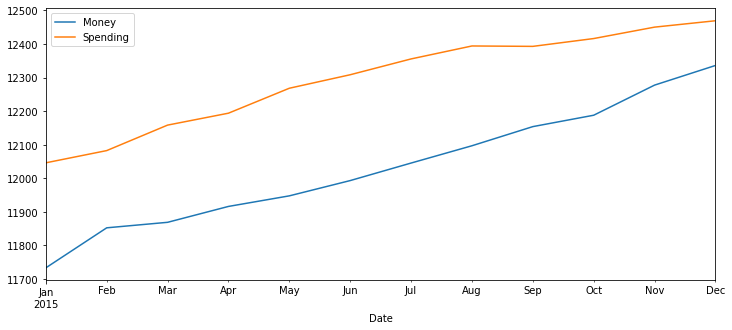

In [55]:
test_range.plot(figsize=(12,5))

<AxesSubplot:>

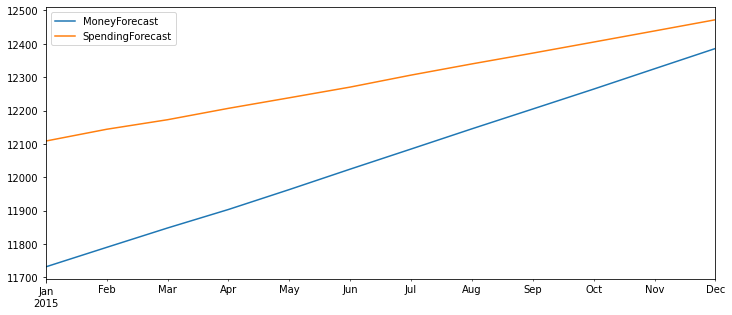

In [57]:
df_predictions[['MoneyForecast', 'SpendingForecast']].plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

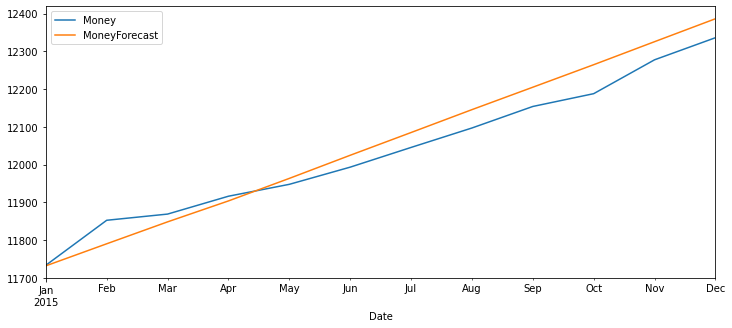

In [61]:
test_range['Money'].plot(figsize=(12,5), legend=True)
df_predictions['MoneyForecast'].plot(figsize=(12,5), legend=True)

<AxesSubplot:xlabel='Date'>

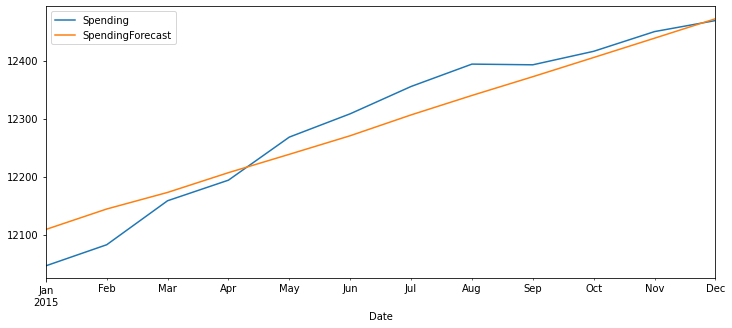

In [62]:
test_range['Spending'].plot(figsize=(12,5), legend=True)
df_predictions['SpendingForecast'].plot(figsize=(12,5), legend=True)

The model easily captured the trends but not seasonality

**Step 8 : Evaluating the Model**

In [63]:
rmse(test_range['Money'], df_predictions['MoneyForecast'])

43.71049653558893

In [64]:
rmse(test_range['Spending'], df_predictions['SpendingForecast'])

37.00117516940808

In [65]:
test_range['Money'].mean()

12034.008333333333

In [66]:
test_range['Spending'].mean()

12294.533333333335

So RMSE is not so bad compare to the mean value, but still we can make a better model.